## Multiple Linear Regression: Predicting Toyota Corolla Prices

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import statsmodels.api as sm

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Load the dataset and view it for better understanding
df=pd.read_csv('ToyotaCorolla - MLR.csv')
df.head()

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


### Exploratory Data Analysis (EDA)


In [47]:
# Check if there are any null values in the dataset
df.isnull().sum()

Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64

In [48]:
df.shape

(1436, 11)

In [49]:
# Identify duplicate values
df[df.duplicated()]

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
113,24950,8,13253,Diesel,116,0,2000,5,4,5,1320


In [50]:
# Remove duplicate values
df.drop_duplicates(keep='first',inplace=True,ignore_index=True)

In [51]:
# Define function for detecting outliers using IQR for all the numerical columns
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to all numerical columns
def remove_outliers_all(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        df = remove_outliers(df, column)
    return df

# Apply the function to the entire dataframe
df_cleaned = remove_outliers_all(df)
df=df_cleaned

# Display the cleaned dataframe
df


,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
9,12950,23,71138,Diesel,69,0,1900,3,4,5,1105
18,16750,24,25563,Petrol,110,0,1600,3,4,5,1065
19,16950,30,64359,Petrol,110,0,1600,3,4,5,1105
20,15950,30,67660,Petrol,110,0,1600,3,4,5,1105
22,15950,28,56349,Petrol,110,0,1600,3,4,5,1120
...,...,...,...,...,...,...,...,...,...,...,...
1430,7500,69,20544,Petrol,86,0,1300,3,4,5,1025
1431,10845,72,19000,Petrol,86,0,1300,3,4,5,1015
1432,8500,71,17016,Petrol,86,0,1300,3,4,5,1015
1433,7250,70,16916,Petrol,86,0,1300,3,4,5,1015


In [52]:
# For more understanding of the data we are working with get the summary statistics
df.describe()

,Price,Age_08_04,KM,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.0,1080.000000,1080.000000,1080.0,1080.0,1080.000000
mean,10005.050926,58.954630,65818.459259,102.856481,0.0,1515.675926,4.037963,4.0,5.0,1055.488889
std,2311.583917,15.268095,27505.396770,10.474947,0.0,132.615412,0.952750,0.0,0.0,27.384569
min,4450.000000,17.000000,1.000000,69.000000,0.0,1300.000000,2.000000,4.0,5.0,1000.000000
25%,8250.000000,49.000000,45648.000000,97.000000,0.0,1400.000000,3.000000,4.0,5.0,1035.000000
50%,9750.000000,62.000000,62993.500000,110.000000,0.0,1600.000000,4.000000,4.0,5.0,1050.000000
75%,11300.000000,71.000000,83438.750000,110.000000,0.0,1600.000000,5.000000,4.0,5.0,1075.000000
max,17200.000000,80.000000,151000.000000,116.000000,0.0,1900.000000,5.000000,4.0,5.0,1135.000000


In [53]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
numerical_columns

['Price',
 'Age_08_04',
 'KM',
 'HP',
 'Automatic',
 'cc',
 'Doors',
 'Cylinders',
 'Gears',
 'Weight']

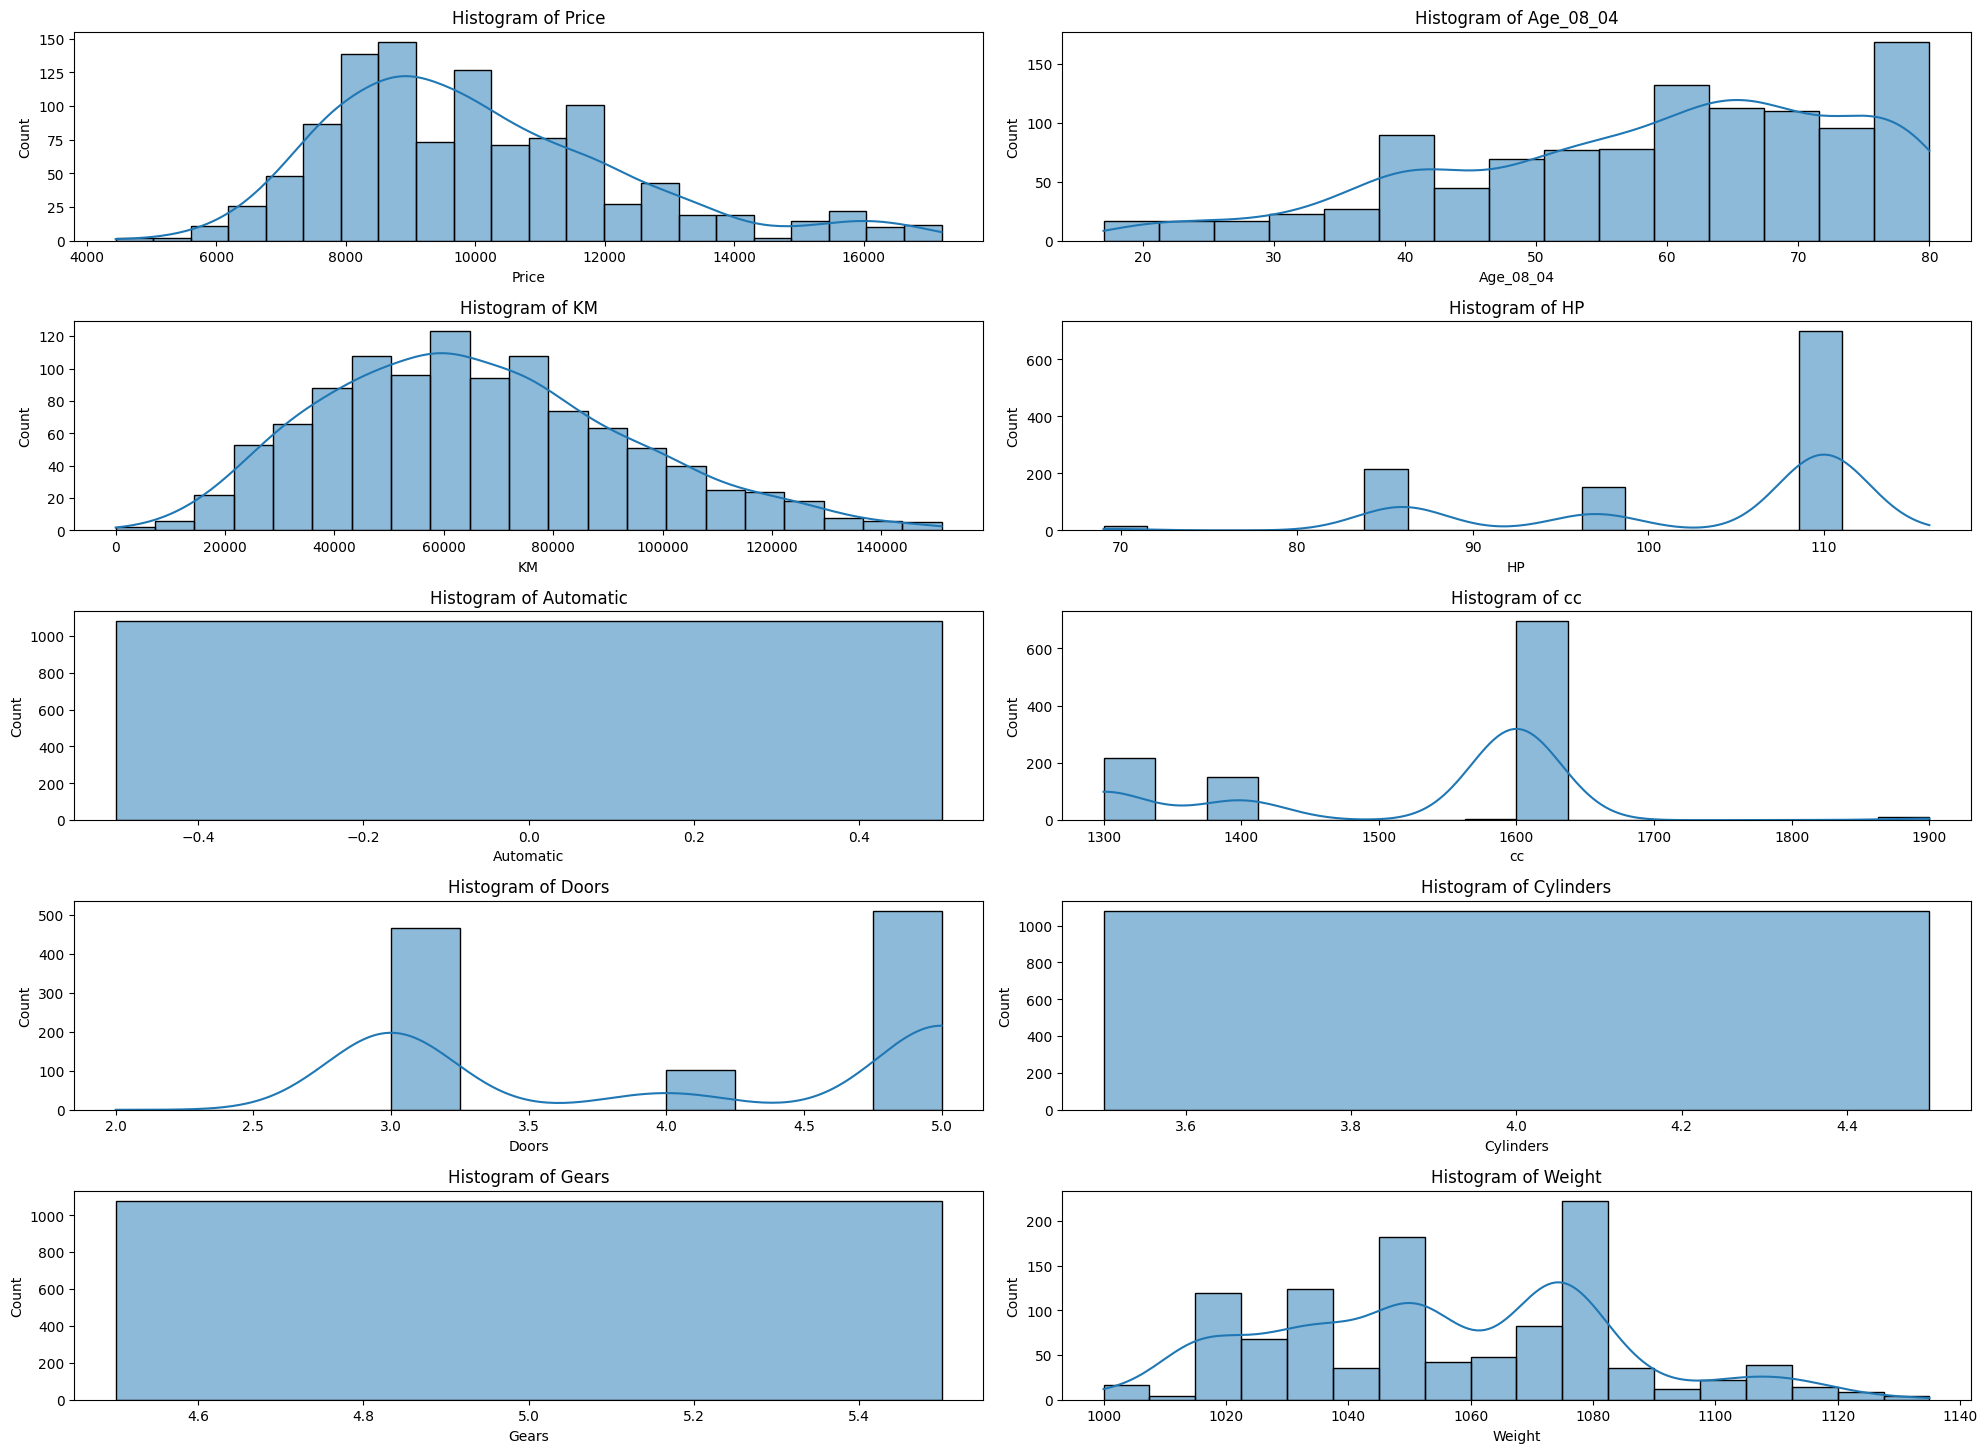

In [54]:
#Plot histograms for the numerical columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(7, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

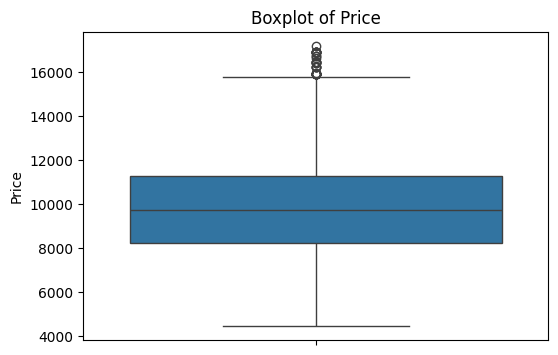

In [55]:
# Verify there are no outliers in the target column(Price)
plt.figure(figsize=(6,4))
sns.boxplot(df['Price'])
plt.title("Boxplot of Price")
plt.show()

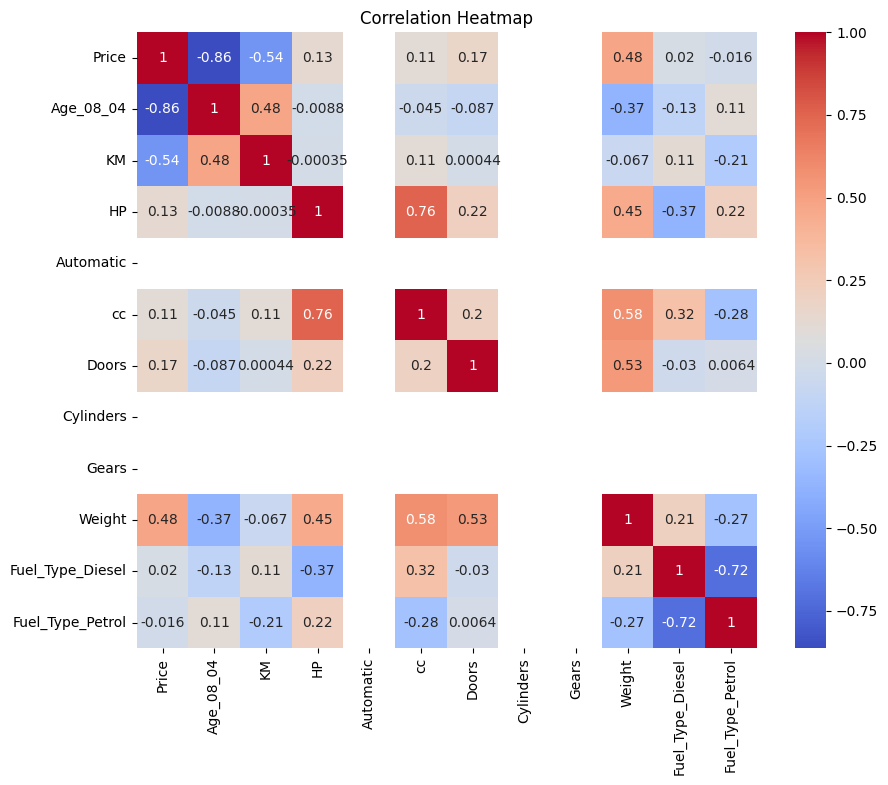

In [62]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [57]:
# Convert categorical variables into dummies
df = pd.get_dummies(df, columns=['Fuel_Type'], drop_first=True)
df

,Price,Age_08_04,KM,HP,Automatic,cc,Doors,Cylinders,Gears,Weight,Fuel_Type_Diesel,Fuel_Type_Petrol
9,12950,23,71138,69,0,1900,3,4,5,1105,1,0
18,16750,24,25563,110,0,1600,3,4,5,1065,0,1
19,16950,30,64359,110,0,1600,3,4,5,1105,0,1
20,15950,30,67660,110,0,1600,3,4,5,1105,0,1
22,15950,28,56349,110,0,1600,3,4,5,1120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1430,7500,69,20544,86,0,1300,3,4,5,1025,0,1
1431,10845,72,19000,86,0,1300,3,4,5,1015,0,1
1432,8500,71,17016,86,0,1300,3,4,5,1015,0,1
1433,7250,70,16916,86,0,1300,3,4,5,1015,0,1


In [58]:
# Seperate Target from Features
x = df.drop(columns=['Price'])
y = df['Price']

In [59]:
# Scaling of numerical features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [60]:
# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

### Build Multiple Linear Regression Models

#### Model 1: Baseline Model (Using all features)

In [27]:
# Fit the baseline model using all features
lm = LinearRegression()
lm.fit(x_train, y_train)

# Predicting the results
y_pred_train = lm.predict(x_train)
y_pred_test = lm.predict(x_test)

# Print coefficients and intercept
print(f"Intercept: {lm.intercept_}")
print(f"Coefficients: {lm.coef_}")

# Evaluation on training set
print(f"Training R^2: {r2_score(y_train, y_pred_train)}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"Training MSE: {mean_squared_error(y_train, y_pred_train)}")

# Evaluation on testing set
print(f"Testing R^2: {r2_score(y_test, y_pred_test)}")
print(f"Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"Testing MSE: {mean_squared_error(y_test, y_pred_test)}")


Intercept: 9967.674793936352
Coefficients: [-1.75442683e+03 -3.30554074e+02 -1.66463234e+03  5.11590770e-13
  1.57584249e+03 -7.46301771e+01  0.00000000e+00  0.00000000e+00
  5.78722672e+02 -1.32060253e+03  1.22646352e+02]
Training R^2: 0.8171882700728873
Training MAE: 763.6483176320097
Training MSE: 962703.2991500759
Testing R^2: 0.8034370721931829
Testing MAE: 810.3378682126151
Testing MSE: 1102448.2185110385


#### Model 2: Feature Selection (Using significant features)

In [31]:
# Adding a constant to X_train for statsmodels
x_train_sm = sm.add_constant(x_train)
model_sm = sm.OLS(y_train, x_train_sm).fit()
print(model_sm.summary())

# Based on p-values, choose only significant features
# Rebuild the model using only those features
# Example: Dropping features with high p-values (>0.05)
significant_features = [ 'KM', 'HP', 'Weight'] # adjust based on results
x_train_sig = x_train[:, [x.columns.get_loc(f) for f in significant_features]]
x_test_sig = x_test[:, [x.columns.get_loc(f) for f in significant_features]]

lm2 = LinearRegression()
lm2.fit(x_train_sig, y_train)

# Evaluation for model 2
y_pred_train2 = lm2.predict(x_train_sig)
y_pred_test2 = lm2.predict(x_test_sig)

print(f"Model 2 Testing R^2: {r2_score(y_test, y_pred_test2)}")


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     477.7
Date:                Mon, 07 Oct 2024   Prob (F-statistic):          2.32e-309
Time:                        17:35:28   Log-Likelihood:                -7177.8
No. Observations:                 864   AIC:                         1.437e+04
Df Residuals:                     855   BIC:                         1.442e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9967.6748     33.573    296.898      0.0

#### Model 3: Polynomial or Interaction Terms

In [32]:
from sklearn.preprocessing import PolynomialFeatures

# Adding polynomial features of degree 2
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

lm3 = LinearRegression()
lm3.fit(x_train_poly, y_train)

# Evaluate model 3
y_pred_train3 = lm3.predict(x_train_poly)
y_pred_test3 = lm3.predict(x_test_poly)

print(f"Model 3 Testing R^2: {r2_score(y_test, y_pred_test3)}")


Model 3 Testing R^2: 0.8028744728528552


### Apply Lasso and Ridge Methods

In [33]:
# Lasso Regression
lasso = LassoCV(cv=5)
lasso.fit(x_train, y_train)

# Lasso Coefficients
print(f"Lasso Coefficients: {lasso.coef_}")

# Ridge Regression
ridge = RidgeCV(cv=5)
ridge.fit(x_train, y_train)

# Ridge Coefficients
print(f"Ridge Coefficients: {ridge.coef_}")

# Evaluation of Lasso and Ridge on testing data
y_pred_lasso = lasso.predict(x_test)
y_pred_ridge = ridge.predict(x_test)

print(f"Lasso Testing R^2: {r2_score(y_test, y_pred_lasso)}")
print(f"Ridge Testing R^2: {r2_score(y_test, y_pred_ridge)}")


Lasso Coefficients: [-1725.94366241  -327.32115549  -987.14664743     0.
   922.54312617   -61.14884657     0.             0.
   558.22967289  -858.9231846    115.75290785]
Ridge Coefficients: [-1751.73354942  -330.43122419 -1606.8665264      0.
  1519.94539369   -73.86152017     0.             0.
   577.52425992 -1281.05752206   122.35302593]
Lasso Testing R^2: 0.8016571451365533
Ridge Testing R^2: 0.803356400574645


### Interview Questions

#### 1.What is Normalization & Standardization and how is it helpful?
**Normalization** scales data to a specific range, typically [0, 1], which helps when features have different scales but no assumptions about their distribution. It's useful for algorithms sensitive to feature magnitude (e.g., KNN, neural networks).

**Standardization** transforms data to have a mean of 0 and a standard deviation of 1. It's helpful when data follows a normal distribution or when features have different scales, ensuring all features contribute equally to models like linear regression and SVM.

Both techniques improve model performance and convergence by making features comparable.
#### 2.What techniques can be used to address multicollinearity in multiple linear regression?
To address multicollinearity in multiple linear regression, the following techniques can be used:

1. **Variance Inflation Factor (VIF):** Identify variables with high VIF values (typically above 5 or 10), indicating multicollinearity. You can remove or combine these variables to reduce the effect.

2. **Ridge Regression:** This regularization technique adds an L2 penalty, shrinking the regression coefficients, which helps reduce the impact of multicollinearity.

3. **Lasso Regression:** Lasso adds an L1 penalty, which can zero out less important features, thus reducing multicollinearity.

4. **Principal Component Analysis (PCA):** PCA reduces the dimensionality of the data by creating uncorrelated principal components, helping to address multicollinearity.

5. **Remove highly correlated features:** Drop one of the features if two or more are highly correlated to each other.